[INFO] No checkpoint found. Training from scratch.
y1_e at t=1.00e-04: pred=1.70e-01, target=6.23e-05, loss=1.18e-02
y1_e at t=1.45e+00: pred=6.86e-03, target=2.03e-07, loss=2.05e-02
y2_e at t=1.00e-04: pred=8.30e-02, target=2.48e-05, loss=1.24e-02
y2_e at t=1.45e+00: pred=2.64e-01, target=2.54e-06, loss=2.52e-02
y_1_e at t=1.00e-04: pred=1.07e-01, target=5.03e-05, loss=1.11e-02
y_1_e at t=1.45e+00: pred=4.52e-03, target=5.27e-09, loss=3.52e-02
y_2_e at t=1.00e-04: pred=8.77e-02, target=2.01e-05, loss=1.33e-02
y_2_e at t=1.45e+00: pred=9.25e-03, target=7.72e-08, loss=2.58e-02
y1_pred: (0.25112706422805786, 0.07543686777353287, 3.3289699273034525)
y1_e at t=1.00e-04: pred=1.76e-01, target=6.23e-05, loss=1.19e-02
y1_e at t=1.45e+00: pred=2.10e-03, target=2.03e-07, loss=1.61e-02
y2_e at t=1.00e-04: pred=3.51e-02, target=2.48e-05, loss=9.93e-03
y2_e at t=1.45e+00: pred=1.11e-01, target=2.54e-06, loss=2.15e-02
y_1_e at t=1.00e-04: pred=7.90e-02, target=5.03e-05, loss=1.02e-02
y_1_e at t=1.4

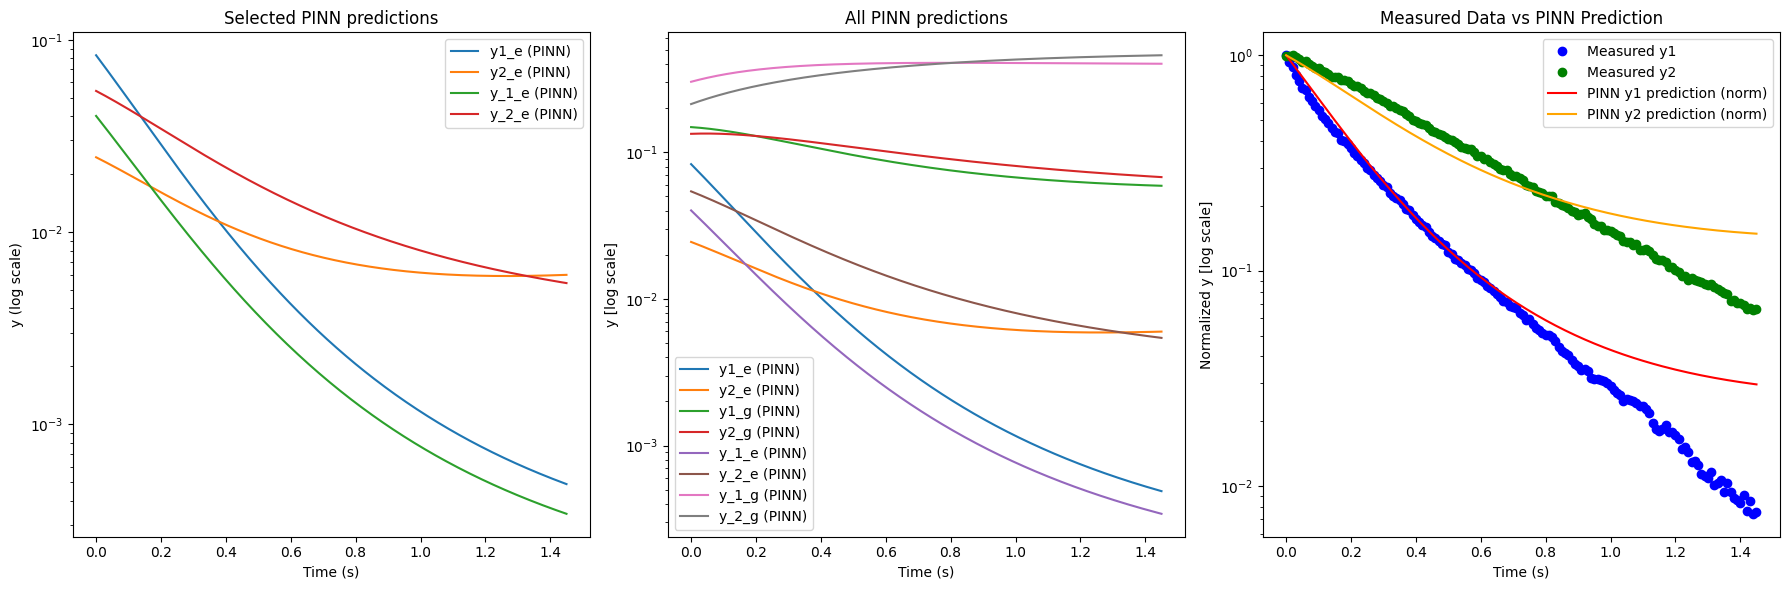

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import nbformat
import os
from scipy.interpolate import interp1d

# 재현성 위한 랜덤 시드 고정
#np.random.seed(42)
#torch.manual_seed(42)
file_path ="./"
# ====================================
# 1. 데이터 로드 및 초기 조건 계산
# ====================================
def load_experiment_data(file_path):
    """
    파일 경로에 있는 데이터를 로드합니다.
    쉼표 또는 공백 구분자를 지원하며, 시간과 값을 반환합니다.
    """
    try:
        data = np.loadtxt(file_path, delimiter=',')
    except ValueError:
        data = np.loadtxt(file_path)
    return data[:, 0], data[:, 1]

# 데이터 파일 경로 (파일이 있는 경로에 맞게 수정)
t_data, y1_e_measured = load_experiment_data(os.path.join(file_path, 'y1_data.txt'))
_, y2_e_measured = load_experiment_data(os.path.join(file_path, 'y2_data.txt'))
t_data = t_data/1e-6
# ====================================
# 2. 설정값 및 초기 조건 계산
# ====================================
# 학습 여부 설정
train_G = False   # G 학습 여부
train_qm = True  # q, m 학습 여부
train_n1 = True # n1, n2 학습 여부
train_n2 = True # n1, n2 학습 여부
train_k = True # k~ 학습 여부
train_w = True # w1, w2, w3~ 학습 여부
"""

"""
w1_fixed = 0.33333
w2_fixed = 0.33333
w3_fixed = 0.33333
G_fixed= 0.1

n2_fixed = 1.

q_fixed = 0.46623028000984335
m_fixed = 0.7274356227283102
kr1_fixed = 2.064563769735658
k12_fixed = 6.347353661077881
k11_fixed = 0.6043115785436436
k22_fixed = 1.2296173744871866
kn1_fixed = 7.850722108600511
n1_fixed = 0.7358983091740485


y_total = 1.0  # 총량

def compute_initial_conditions(q_val, m_val):
    """
    q_val, m_val 둘 다 nn.Parameter (requires_grad=True)일 때
    -> Torch 텐서로 IC를 계산해 반환.
    """
    if train_qm:
        # 예: torch.stack([...]) 형태
        #필요하면 y_total을 곱해도 되는데, 그 또한 Torch 스칼라로 만들어야 하기때문에 여기서 생략--------------매우 중요!!!.
        return torch.stack([
            torch.zeros([], dtype=q_val.dtype, device=q_val.device),
            torch.zeros([], dtype=q_val.dtype, device=q_val.device),
            m_val*(1 - q_val),
            (1 - m_val)*(1 - q_val),
            torch.zeros([], dtype=q_val.dtype, device=q_val.device),
            torch.zeros([], dtype=q_val.dtype, device=q_val.device),
            m_val*q_val,
            (1 - m_val)*q_val
        ])
    else:
        # 여기서는 float로만 쓰겠다
        q_float = q_val  # or q_val.detach().cpu().numpy()[0] 등
        m_float = m_val

        return np.array([
            0.0, 0.0,
            m_float*(1 - q_float)*y_total,
            (1 - m_float)*(1 - q_float)*y_total,
            0.0, 0.0,
            m_float*q_float*y_total,
            (1 - m_float)*q_float*y_total
        ])

# ====================================
# 4. PINN 모델 정의
# ====================================
"""
PINN 모델: 신경망을 통해 시간에 따른 8개 상태를 예측하고,
물리 법칙(ODE)을 기반으로 한 손실을 함께 계산합니다.
"""
class ODESolverPINN(nn.Module):
    def __init__(self, input_dim=1, output_dim= 8, hidden_dim= 64, model_type='ANN', **kwargs):
        super(ODESolverPINN, self).__init__()
        self.model_type = model_type
        
        # 학습할 파라미터 또는 고정값 설정
        self.G = nn.Parameter(torch.tensor(G_fixed, dtype=torch.float32)) if train_G else G_fixed
        self.q = nn.Parameter(torch.tensor(q_fixed, dtype=torch.float32)) if train_qm else q_fixed
        self.m = nn.Parameter(torch.tensor(m_fixed, dtype=torch.float32)) if train_qm else m_fixed
        self.n1 = nn.Parameter(torch.tensor(n1_fixed, dtype=torch.float32)) if train_n1 else n1_fixed
        self.n2 = nn.Parameter(torch.tensor(n2_fixed, dtype=torch.float32)) if train_n2 else n2_fixed
        self.w1 = nn.Parameter(torch.tensor(w1_fixed, dtype=torch.float32)) if train_w else w1_fixed
        self.w2 = nn.Parameter(torch.tensor(w2_fixed, dtype=torch.float32)) if train_w else w2_fixed
        self.w3 = nn.Parameter(torch.tensor(w3_fixed, dtype=torch.float32)) if train_w else w3_fixed

        # 반응 속도 상수 (학습 파라미터)
        self.kr1 = nn.Parameter(torch.tensor(kr1_fixed, dtype=torch.float32)) if train_k else kr1_fixed
        self.k12 = nn.Parameter(torch.tensor(k12_fixed, dtype=torch.float32)) if train_k else k12_fixed
        self.k11 = nn.Parameter(torch.tensor(k11_fixed, dtype=torch.float32)) if train_k else k11_fixed
        #self.kr2 = nn.Parameter(torch.tensor(kr2_fixed, dtype=torch.float32)) if train_k else kr2_fixed
        self.k22 = nn.Parameter(torch.tensor(k22_fixed, dtype=torch.float32)) if train_k else k22_fixed
        self.kn1 = nn.Parameter(torch.tensor(kn1_fixed, dtype=torch.float32)) if train_k else kn1_fixed
        #self.kn2 = nn.Parameter(torch.tensor(kn2_fixed, dtype=torch.float32)) if train_k else kn2_fixed
        
        
        if model_type == 'ANN':
            # 기존 ANN 신경망 구조 (예시로 2개의 은닉층)
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, hidden_dim)
            self.fc_out = nn.Linear(hidden_dim, output_dim)
        
        elif model_type == 'LSTM':
            # LSTM 레이어와 출력층
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=3, batch_first=True)
            self.fc_out = nn.Linear(hidden_dim, output_dim)
        
        elif model_type == 'GRU':
            # GRU 레이어와 출력층
            self.gru = nn.GRU(input_dim, hidden_dim, num_layers=1, batch_first=True)
            self.fc_out = nn.Linear(hidden_dim, output_dim)
        
        elif model_type == 'Transformer':
            # Transformer 인코더 레이어와 출력층
            d_model = 8   # 모델 차원 (필요에 따라 조정 가능)
            nhead = 4           # 멀티헤드 어텐션 헤드 수 (예시값)
            num_layers = 1      # 인코더 레이어 개수 (예시값)
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
            self.linear_in = nn.Linear(input_dim, d_model)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # ANN 모델 forward: 기존 완전연결 신경망
        if self.model_type == 'ANN':
            if x.dim() != 2 or x.shape[1] != 1:
                raise ValueError(f"Expected t shape (batch_size, 1), but got {x.shape}")
            #x_scaled = x / (2.0e-6)
            out = torch.tanh(self.fc1(x))
            out = torch.tanh(self.fc2(out))
            out = torch.tanh(self.fc3(out))
            out = self.fc_out(out)
            # #### CHANGED: 최종단에서 sigmoid로 0~1 범위 확보
            #out = torch.sigmoid(x)   # (0, 1)
            out = torch.softmax(out, dim=1)

            return out
        
        # LSTM 모델 forward
        elif self.model_type == 'LSTM':
            # 입력 크기를 (배치, 시퀀스, 특징)로 맞춤 (시퀀스 길이가 없는 경우 1로 설정)
            if x.dim() == 2:
                x = x.unsqueeze(1)  # (batch, 1, feature)
            lstm_out, _ = self.lstm(x)          # lstm_out: (batch, seq_len, hidden_dim)
            out = lstm_out[:, -1, :]            # 마지막 시점 출력 (batch, hidden_dim)
            out = self.fc_out(out)              # 출력층 통과 (batch, output_dim)
            out = torch.softmax(out, dim=1)
            return out
        
        # GRU 모델 forward
        elif self.model_type == 'GRU':
            if x.dim() == 2:
                x = x.unsqueeze(1)  # (batch, 1, feature)
            gru_out, _ = self.gru(x)            # gru_out: (batch, seq_len, hidden_dim)
            out = gru_out[:, -1, :]             # 마지막 시점 출력
            out = self.fc_out(out)              # 출력층 통과
            out = torch.softmax(out, dim=1)
            return out
        
        # Transformer 모델 forward
        elif self.model_type == 'Transformer':
            if x.dim() == 2:
                x = x.unsqueeze(1)              # (batch, 1, feature)
            # Transformer 입력 차원 변환: (batch, seq, feature) -> (seq, batch, feature)
            x_seq = x.permute(1, 0, 2)
            trans_out = self.transformer_encoder(x_seq)  # (seq, batch, d_model)
            trans_out = trans_out.permute(1, 0, 2)      # (batch, seq, d_model)로 변환
            out = trans_out[:, -1, :]             # 마지막 시점 벡터 (batch, d_model)
            out = self.fc_out(out)                  # 출력층 통과 (batch, output_dim)
            out = torch.softmax(out, dim=1)
            return out
    
    def get_y1_y2_prediction(self, t):
        """
        측정 데이터와 비교하기 위한 y1, y2 값을 계산합니다.
        """
        y_pred = self(t)
        n1 = self.n1 if train_n1 else n1_fixed
        n2 = self.n2 if train_n2 else n2_fixed
        # y1, y2 계산: 네트워크 예측 값의 특정 조합 (모델에 맞게 수정 가능)
        y1 = n1 * (y_pred[:, 0] + y_pred[:, 4]) + (1 - n1) * (y_pred[:, 1] + y_pred[:, 5])
        y2 = n2 * (y_pred[:, 1] + y_pred[:, 5]) + (1 - n2) * (y_pred[:, 0] + y_pred[:, 4])
        return y1, y2
    
    
    # =============================================================================
    # 이 함수가 벡터 연산으로 수정되었습니다.
    # =============================================================================
    def compute_physics_loss(self, t_collocation):
        """
        물리법칙(ODE)을 기반으로 한 손실을 계산합니다. (벡터 연산으로 효율화)
        """
        y_pred = self(t_collocation)
        
        # 1. 신경망 출력으로부터 각 변수를 벡터 형태로 분리
        # y_pred의 shape는 (batch_size, 8)이며, 각 변수는 (batch_size,) 형태의 벡터가 됨
        y1_e, y2_e, y1_g, y2_g, y_1_e, y_2_e, y_1_g, y_2_g = y_pred.T

        # 2. 신경망 예측값의 시간에 대한 미분 계산 (NN의 예측 기울기)
        dy_dt_list = [torch.autograd.grad(y_pred[:, i], t_collocation,
                                       grad_outputs=torch.ones_like(y_pred[:, i]),
                                       retain_graph=True, create_graph=True)[0] for i in range(8)]
        # 미분값 리스트를 (batch_size, 8) 형태의 단일 텐서로 결합
        nn_derivatives = torch.cat(dy_dt_list, dim=1)
        
        # 3. 학습 가능한 파라미터 가져오기 (값은 스칼라)
        G_val = self.G
        kr1_val = self.kr1
        k12_val = self.k12
        k11_val = self.k11
        k22_val = self.k22
        kn1_val = self.kn1
        
        # 4. ODE 방정식을 이용해 물리 법칙 기반의 미분값 계산 (전체 배치에 대해 한 번에)
        # G_t: t < 1e-4 조건에 따라 G 또는 0을 갖는 벡터
        # t_collocation은 (batch_size, 1)이므로 squeeze(-1)로 (batch_size,)로 만듦
        G_t = torch.where(t_collocation.squeeze(-1) < 1e-4, G_val, 0.0)
        
        # 벡터 연산을 통해 전체 배치에 대한 ODE 미분값 계산
        pred_dy1_e = G_t * y1_g - kr1_val * y1_e - k12_val * y1_e * y2_g - k11_val * y1_e * y_1_g - k12_val * y1_e * y_2_g + k11_val * y_1_e * y1_g
        pred_dy2_e = G_t * y2_g - kr1_val * y2_e + k12_val * y1_e * y2_g - k22_val * y2_e * y_2_g + k12_val * y_1_e * y2_g + k22_val * y_2_e * y2_g
        pred_dy1_g = -pred_dy1_e
        pred_dy2_g = -pred_dy2_e
        pred_dy_1_e = G_t * y_1_g - (kr1_val + kn1_val) * y_1_e + k11_val * y1_e * y_1_g - k12_val * y_1_e * y2_g - k11_val * y_1_e * y1_g - k12_val * y_1_e * y_2_g
        pred_dy_2_e = G_t * y_2_g - (kr1_val + kn1_val) * y_2_e + k12_val * y1_e * y_2_g + k22_val * y2_e * y_2_g + k12_val * y_1_e * y_2_g - k22_val * y_2_e * y2_g
        pred_dy_1_g = -pred_dy_1_e
        pred_dy_2_g = -pred_dy_2_e
        
        # 계산된 미분값들을 (batch_size, 8) 텐서로 결합
        ode_derivatives = torch.stack([pred_dy1_e, pred_dy2_e, pred_dy1_g, pred_dy2_g,
                                       pred_dy_1_e, pred_dy_2_e, pred_dy_1_g, pred_dy_2_g], dim=1)

        # 5. 두 미분값의 차이(잔차) 제곱의 평균을 손실로 계산
        loss_physics = torch.mean((nn_derivatives - ode_derivatives)**2)
        
        return loss_physics


# =========================================================================================================================================
# 5. 학습 및 시뮬레이션
# =========================================================================================================================================
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# =========================================================================================================================================
# 6. 결과 시각화 및 ODE 시뮬레이션
# =========================================================================================================================================
def plot_pinn_prediction_vs_data(model,
                                         device,
                                         t_data,
                                         y1_e_measured,
                                         y2_e_measured
                                         ):
        """
        PINN 예측 vs 실측데이터 비교 시각화 (ODE 시뮬레이션 부분 제거).
        """

        # 1) PINN 예측 결과 (8개 상태변수) 시각화
        t_test = torch.linspace(0, 1.45, steps=400).view(-1, 1).to(device)
        y_pred = model(t_test).detach().cpu().numpy()
        
        labels = ['y1_e', 'y2_e', 'y1_g', 'y2_g', 'y_1_e', 'y_2_e', 'y_1_g', 'y_2_g']
        
        # Create figure with 3 subplots
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

        # First subplot
        ax1.set_yscale('log')
        ax1.plot(t_test.cpu().numpy(), np.abs(y_pred[:, 0]), label=f'{labels[0]} (PINN)')
        ax1.plot(t_test.cpu().numpy(), np.abs(y_pred[:, 1]), label=f'{labels[1]} (PINN)')
        ax1.plot(t_test.cpu().numpy(), np.abs(y_pred[:, 4]), label=f'{labels[4]} (PINN)')
        ax1.plot(t_test.cpu().numpy(), np.abs(y_pred[:, 5]), label=f'{labels[5]} (PINN)')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('y (log scale)')
        ax1.legend()
        ax1.set_title('Selected PINN predictions')

        # Second subplot
        ax2.set_yscale('log')
        for i in range(8):
            ax2.plot(t_test.cpu().numpy(), np.abs(y_pred[:, i]), label=f'{labels[i]} (PINN)') 
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel("y [log scale]")
        ax2.legend()
        ax2.set_title('All PINN predictions')

        # Third subplot - PINN vs measured data
        t_data_tensor = torch.tensor(t_data.reshape(-1, 1), dtype=torch.float32).to(device)
        with torch.no_grad():
            y1_pinn, y2_pinn = model.get_y1_y2_prediction(t_data_tensor)
            y1_pinn = y1_pinn.cpu().numpy()
            y2_pinn = y2_pinn.cpu().numpy()

        # 측정 데이터, PINN 예측 각각 정규화
        y1_measured_norm = y1_e_measured / np.max(y1_e_measured)
        y2_measured_norm = y2_e_measured / np.max(y2_e_measured)
        y1_pinn_norm = y1_pinn / np.max(y1_pinn)
        y2_pinn_norm = y2_pinn / np.max(y2_pinn)

        ax3.set_yscale('log')
        ax3.plot(t_data, y1_measured_norm, 'o', label='Measured y1',c='b')
        ax3.plot(t_data, y2_measured_norm, 'o', label='Measured y2',c='g')
        ax3.plot(t_data, y1_pinn_norm, 'r-', label='PINN y1 prediction (norm)')
        ax3.plot(t_data, y2_pinn_norm, 'orange', label='PINN y2 prediction (norm)')
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("Normalized y [log scale]")
        ax3.legend()
        ax3.set_title("Measured Data vs PINN Prediction")

        plt.tight_layout()
        # plt.show()  # 이 줄을 제거하거나 주석 처리
        # 함수는 figure를 생성만 하고, 표시나 저장은 호출하는 쪽에서 처리
        


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ODESolverPINN(input_dim=1, output_dim=8, hidden_dim=64, model_type='ANN').to(device)
    
    # #### CHANGED: 모델 전체 레이어에 대해 Xavier 초기화 적용
    model.apply(init_weights)
    
    # 옵티마이저 및 학습 하이퍼파라미터
    num_epochs = 27000
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    """ 파라메터별로 러닝레이트 따로 선정해주기 (PINN파라메터는 느리게 정상적으로 나머지 파리메터는 빠르게!! --------------"""
    #""" 파라메터별로 러닝레이트 따로 선정해주기 (PINN파라메터는 느리게 정상적으로 나머지 파리메터는 빠르게!! --------------"""
    nn_params=[]
    non_nn_params=[]
    for name, param in model.named_parameters():
        if name in ['kr1', 'k12', 'k11', 'k22', 'kn1', 'q', 'm']:  # 나머지 파라미터
            non_nn_params.append(param)
        else:
            nn_params.append(param)
    optimizer = torch.optim.Adam([
    {'params': nn_params, 'lr': 1e-4},
    {'params': non_nn_params, 'lr': 1e-3}  
    ])
    
    """ 체크포인트 파일 경로--------------------------------------------------------------------------------------"""
    checkpoint_path = "./pth_file_name.pth"  
    
    # -----------------------------
    # 1) 체크포인트 로드(있으면)
    # -----------------------------
    start_epoch = 0
    best_loss   = float('inf')  # 혹은 np.inf
    if os.path.isfile(checkpoint_path):
        print(f"[INFO] Found checkpoint at {checkpoint_path}. Loading...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        best_loss   = checkpoint["best_loss"]
        print(f"[INFO] Resuming training from epoch {start_epoch} (best_loss={best_loss:.4e})")
    else:
        print("[INFO] No checkpoint found. Training from scratch.")
    """ 체크포인트 파일 경로끝--------------------------------------------------------------------------------------"""
    
    # 측정 데이터 텐서
    t_data_tensor = torch.tensor(t_data.reshape(-1, 1), dtype=torch.float32).to(device)
    y1_measured_tensor = torch.tensor(y1_e_measured, dtype=torch.float32).to(device)
    y2_measured_tensor = torch.tensor(y2_e_measured, dtype=torch.float32).to(device)


    t_candidates = np.arange(0, 1.45 + 1e-4, 1e-4)
    n_collocation = 300  # 매 epoch마다 샘플링할 collocation point 수(원하는 대로 조절)
    
    # Boundary value settings
    boundary_times = np.array([1e-4, 1.4499])  # Time points for boundary conditions (can be modified)
    boundary_values = {                                                                                         
        'y1_e': np.array([6.229976522084205e-05, 2.0279821507736704e-07]),   
        'y2_e': np.array([2.4819144113945404e-05, 2.5379156920339318e-06]),   
        'y_1_e': np.array([5.030875421072617e-05, 5.272093839675564e-09]),  
        'y_2_e': np.array([2.0078386750587773e-05, 7.722963031635555e-08])   
    }

    out_log = []
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # 1) zero_index(t=0, 1e-10 )을 제외한 구간에서 n_collocation-1개를 랜덤 추출
        other_indices = np.arange(2, len(t_candidates))  # 1부터 끝까지
        rand_indices = np.random.choice(other_indices, n_collocation - 1, replace=False)

        # 2) 인덱스 합치기: [0] + rand_indices

        collocation_indices = np.concatenate(([0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1],[0],[1], rand_indices))#t=0,1e-10두번씩나오게!

        # 3) 해당 인덱스로 t_collocation 생성
        t_collocation = torch.tensor(
            t_candidates[collocation_indices],
            dtype=torch.float32
        ).view(-1, 1).to(device)

        t_collocation.requires_grad = True

        
        # (A) data loss

        y1_pred, y2_pred = model.get_y1_y2_prediction(t_data_tensor)
        y1_pred_norm = y1_pred / torch.max(y1_pred)
        y2_pred_norm = y2_pred / torch.max(y2_pred)
        y1_measured_norm = y1_measured_tensor / torch.max(y1_measured_tensor)
        y2_measured_norm = y2_measured_tensor / torch.max(y2_measured_tensor)
        loss_data = torch.mean((y1_pred_norm - y1_measured_norm)**2) + torch.mean((y2_pred_norm - y2_measured_norm)**2)
        

        # (B) physics loss
        loss_physics = model.compute_physics_loss(t_collocation)

        
        # 초기조건 텐서 준비:  train_qm에 따라 q, m이 학습 변수인지 또는 고정값인지에 따라 가져오는 방식
        #q, m이 학습 상한,하한 주기

        # (C) IC loss: t=0에서 모델 출력 vs 실제 초기조건
        t0 = torch.zeros((1, 1), dtype=torch.float32, device=device)
        y_pred_init = model(t0)   # shape=(1,8)

        if train_qm:
            ic_tensor = compute_initial_conditions(model.q, model.m)
            ic_tensor = ic_tensor.unsqueeze(0)
        else:
            q_val = q_fixed
            m_val = m_fixed
            ic_np = compute_initial_conditions(q_val, m_val)
            ic_tensor = torch.tensor(ic_np, dtype=torch.float32, device=device).unsqueeze(0)

        # 수정된 IC loss 계산
        loss_IC = 0
        epsilon = 1e-12 
        max_loss = 10.0  # 더 작은 최대 loss 값으로 제한
        scale_factor = 0.1  # 추가적인 스케일링 팩터
        
        for index in range(len(y_pred_init[0])):
            pred_val = y_pred_init[0][index]
            true_val = ic_tensor[0][index]
            
            # 단순화된 상대 오차 계산
            if abs(true_val) < epsilon:
                # true_val이 0에 가까운 경우 (indices 0, 1, 4, 5)
                rel_loss = (pred_val**2)  # 예측값이 0에 가까워야 함
            else:
                # true_val이 0이 아닌 경우
                rel_loss = ((pred_val - true_val) / (abs(true_val) + epsilon))**2
            
            # loss 값 제한 및 스케일링
            rel_loss = torch.min(rel_loss, torch.tensor(max_loss).to(device)) * scale_factor
            
            # 가중치 적용 (더 작은 가중치 사용)
            if index in [0, 1, 4, 5]:
                loss_IC += 5 * rel_loss   
            else:
                loss_IC += rel_loss

        # 전체 loss를 정규화
        loss_IC = loss_IC / len(y_pred_init[0])

        # Calculate boundary loss
        t_bound = torch.tensor(boundary_times.reshape(-1, 1), dtype=torch.float32).to(device)
        y_bound = model(t_bound)  # Shape: (num_boundary_points, 8)

        loss_bound = 0
        epsilon = 1e-12 
        scale_factor = 1e-3  # 매우 작은 스케일링 팩터 사용

        # y1_e is index 0, y2_e is index 1, y_1_e is index 4, y_2_e is index 5
        bound_indices = {'y1_e': 0, 'y2_e': 1, 'y_1_e': 4, 'y_2_e': 5}
            
        for var_name, idx in bound_indices.items():
            target_values = torch.tensor(boundary_values[var_name], dtype=torch.float32).to(device)
            pred_values = y_bound[:, idx]
            
            var_loss = 0
            for i, (pred, target) in enumerate(zip(pred_values, target_values)):
                # 수정된 loss 계산
                if abs(target) < epsilon:
                    point_loss = pred**2
                else:
                    # log scale에서의 차이를 사용
                    log_pred = torch.log10(pred + epsilon)
                    log_target = torch.log10(target + epsilon)
                    point_loss = (log_pred - log_target)**2
                
                var_loss += point_loss * scale_factor
                
                # 디버깅 출력
                if (epoch+1) % 200 == 0:
                    print(f"{var_name} at t={boundary_times[i]:.2e}: pred={pred:.2e}, target={target:.2e}, loss={point_loss*scale_factor:.2e}")
            
            loss_bound += var_loss
        
        # 전체 loss를 데이터 포인트 수로 정규화
        total_points = len(bound_indices) * len(boundary_times)
        loss_bound = loss_bound / total_points


    # 최종 loss---------------------최종 loss----------------------최종 loss-----------------------최종 loss--------------------------------------------
    #========================================================================================================================
        loss = model.w1*loss_data + model.w2*loss_physics  + model.w3*(loss_IC + loss_bound)   
        loss.backward()
        optimizer.step()
        if train_qm:
            with torch.no_grad():
                model.q.clamp_(min=0.2, max=0.8)
                model.m.clamp_(min=0.2, max=0.8)                          
        if train_w:
            with torch.no_grad():
                # 먼저 음수 방지
                model.w1.clamp_(min=0.1)
                model.w2.clamp_(min=0.1)
                model.w3.clamp_(min=0.1)

                # 정규화: 세 가중치의 합이 항상 1이 되도록
                total = model.w1 + model.w2 +  model.w3 + 1e-12  #model.w3 + 0 나눗셈 방지용 epsilon  
                model.w1.copy_(model.w1 / total)
                model.w2.copy_(model.w2 / total)
                model.w3.copy_(model.w3 / total)     
        if train_k:
            with torch.no_grad():
                model.kr1.data.clamp_(min=0.1)
                model.k11.data.clamp_(min=0.1)
                model.k12.data.clamp_(min=0.1)
                model.k22.data.clamp_(min=0.1)
                model.kn1.data.clamp_(min=0.1)
        
        if (epoch+1) % 20 == 0:
            out_log.append([epoch+1, loss.item(), loss_data.item(), loss_physics.item(), loss_IC.item(), loss_bound.item()])
              
            if (epoch+1) % 200 == 0:
                print(f"y1_pred: {y1_pred[0].item(),y1_pred[-1].item(), y1_pred[0].item()/y1_pred[-1].item() }") 
                """40~50 근처로 나올때 까지 보고 체크포인트 따로 저장하라"""
         
        # 2) 체크포인트 저장# -------------------------------------------------------------------------
        #   - 예: 1000번마다 저장
        if (epoch+1) % 1000 == 0:
            # 성능이 더 좋아졌다면 best_loss 갱신
            current_loss = loss.item()
            if current_loss < best_loss:
                best_loss = current_loss

            
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_loss": best_loss
            }, checkpoint_path)
            
            print(f"[Checkpoint] Saved at epoch {epoch+1}, best_loss={best_loss:.4e}")
            
            plot_pinn_prediction_vs_data(model=model,
                                 device=device,
                                 t_data=t_data,
                                 y1_e_measured=y1_e_measured,
                                 y2_e_measured=y2_e_measured)
            # 화면에도 표시 (non-blocking mode)
            plt.show(block=False)
            plt.pause(1)  # 1초 동안 그래프 표시
            plt.close('all')
            
            # 에포크 수에 따라 2000 에포크마다 체크포인트 저장 및 시각화
        if epoch + 1 >= 14000 and (epoch + 1) % 2000 == 0:
            current_loss = loss.item()
            if current_loss < best_loss:
                best_loss = current_loss
    
            # 체크포인트 저장
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_loss": best_loss
            }, checkpoint_path[:-4] +f"_{epoch+1}.pth")  # 에포크 번호 포함하여 저장
    
            print(f"[Checkpoint] Saved at epoch {epoch+1}, best_loss={best_loss:.4e}")
    
            # 예측 결과 시각화 및 저장
            plot_pinn_prediction_vs_data(model=model,
                                         device=device,
                                         t_data=t_data,
                                         y1_e_measured=y1_e_measured,
                                         y2_e_measured=y2_e_measured)
    
            # 에포크 번호를 포함한 파일명으로 저장
            plt.savefig(f'epoch={epoch+1}.svg')
            plt.show(block=False)
            plt.pause(1)
            plt.close('all')
            
    # 학습 완료 후 학습된 모든 파라미터 출력 (main() 내에서 model 사용)
    print("\n=== 학습된 파라미터 출력 ===")
    for name, param in model.named_parameters():
        if param.numel() == 1:
            print(f"{name}: {param.item()}")
        else:
            # 텐서의 shape와 평균값을 출력 (또는 원하는 다른 통계값)
            print(f"{name}: shape={param.shape}, mean={param.mean().item():.4f}")
    print("Training complete!")

    out_log = np.array(out_log)
    np.savetxt("Learning_curve.csv", out_log, delimiter=',')
    
# =========================================================================================================================================
# 5. 학습 및 시뮬레이션 끝!!!
# =========================================================================================================================================
        
    
if __name__ == '__main__':
    main()